# Error on ages

Author: Remy Clement

Course Project, UC Irvine, Math 10, W22

## Introduction


First I am going to clean up and dataframe about artist so that it is usable for scikit learn.  The I will use k-neareast-neighbors regressor to predict artist death dates from there birth dates and and finding the error of the predictions.  I will also see how changing k will affect the train and test error.

## Error



In [ ]:
from tqdm.std import tqdm, trange
from tqdm import notebook
notebook.tqdm = tqdm
notebook.trange = trange

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import altair as alt

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I need to first load a dataset

In [ ]:
df=pd.read_csv('Artworks.csv')

In [ ]:
df

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)
0,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,...,http://www.moma.org/media/W1siZiIsIjU5NDA1Il0s...,NaN,NaN,NaN,48.6000,NaN,NaN,168.9000,NaN,NaN
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,...,http://www.moma.org/media/W1siZiIsIjk3Il0sWyJw...,NaN,NaN,NaN,40.6401,NaN,NaN,29.8451,NaN,NaN
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...",...,http://www.moma.org/media/W1siZiIsIjk4Il0sWyJw...,NaN,NaN,NaN,34.3000,NaN,NaN,31.8000,NaN,NaN
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,...,http://www.moma.org/media/W1siZiIsIjEyNCJdLFsi...,NaN,NaN,NaN,50.8000,NaN,NaN,50.8000,NaN,NaN
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...",...,http://www.moma.org/media/W1siZiIsIjEyNiJdLFsi...,NaN,NaN,NaN,38.4000,NaN,NaN,19.1000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132398,An Episode in the Life of a Landscape Painter ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,Book from a multiple of archival carrying case...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132399,Incense Sweaters & Ice (Installation),Martine Syms,68036,"(American, 1988)",(American),(1988),(0),(),2017,"Video (color, sound)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500.0
132400,Just For You,Ken Friedman,2007,"(American, born 1949)",(American),(1939),(0),(Male),1967,NaN,...,NaN,NaN,0.0,NaN,0.0000,NaN,NaN,0.0000,NaN,NaN
132401,Marey and Demeny Chronophotographs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1892–1900,"35mm film (black and white, silent)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.0


Here I am dropping all the columns that might not I do not want/need

In [ ]:
df = df.drop(df.columns[[2,9,10,11,12,13,14,16,17,18,19,20,21,22,24,25,27,28]], axis=1)

Here I am going to drop n amount of rows, since altair chart cannot work with large amounts of data (here n being 130000)

In [ ]:
n=130000

In [ ]:
df.drop(df.tail(n).index,
        inplace = True)

Here we are droping na values from the whole dataframe

In [ ]:
df=df.dropna()

I at first thought that I needed to drop decimales, or only have the in the tenth place at the furthest but realized the was not really needed; although I still decided to keep it.

In [ ]:
df['Width (cm)']=df['Width (cm)']. round(decimals=1)
df['Height (cm)']=df['Height (cm)']. round(decimals=1)

In the next four cells I am taking each value from the BeginDate and EndDate and removing its first and last component, corresponding to the 1 and 5.  I am doing this because the dates are trapped in parentheses, ex: (1999), and I need only numrical value inside them.  So first I remove the parentses from there then I turn that value into a float value, since even after romeving the parenttheses it still had a object datatype

In [ ]:
df['BeginDate']=df['BeginDate'].map(lambda n: (n[1:5]))

In [ ]:
df['BeginDate']=pd.to_numeric(df["BeginDate"], errors=("coerce"))

In [ ]:
df['EndDate']=df['EndDate'].map(lambda n: (n[1:5]))

In [ ]:
df['EndDate']=pd.to_numeric(df["EndDate"], errors=("coerce"))

Importing libraries for regression

In [ ]:
from numpy.random import default_rng
rng = default_rng()
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

Here I am going to plot the year an Artist was born on x axis with he year the they died on the y axis.  As you go further up and to the right it shows artist that have lived closer to the present.  Also it makes sne that there are no outliers in the top left and bottom right corner, since for the top left it would mean someone lived for a non phesable amount of time and bottom right where it would mean that a person is born after they died, it doesnt make sense.

In [ ]:
alt.Chart(df).mark_circle().encode(
    x = alt.X("BeginDate", scale=alt.Scale(domain=(1730, 2040))),
    y =alt.Y("EndDate", scale=alt.Scale(domain=(1730, 2040))),
    tooltip ='Artist'
).properties(title='Lifetime')

alt.Chart(...)

Here in am dropping nan values from the 'BeginDate' and 'EndDate' columns.

In [ ]:
df.dropna(subset=['BeginDate'], inplace=True)

In [ ]:
df.dropna(subset=['EndDate'], inplace=True)

In [ ]:
#df2=df
#i=700
#df.drop(df.tail(i).index,
#        inplace = True)

Was planning on removing a lot of rows to the dataframe so it would actually be much easire to interprets these graphs below since there wouldn't be nearly as many artists.  With this many all there names overlap so we cannot really pick out a single artist of our choice.  Was planning on doing this with code above this cell but it was removing 700 rows from my original data frame, as well, which I couldn't find out why.

In these graphs below we can see how the birth date and death death of the various artists and how they bounce around from artist to artist. 

<AxesSubplot:xlabel='Artist'>

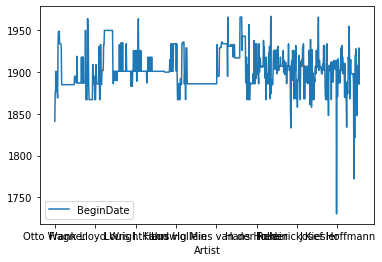

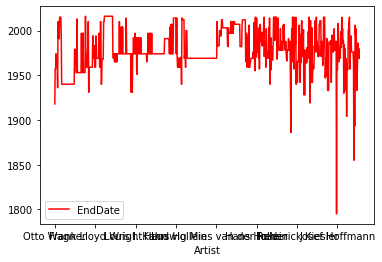

In [ ]:
df.plot(kind='line',x='Artist',y='BeginDate')
df.plot(kind='line',x='Artist',y='EndDate', color='red')

Not so important to rescale the data here since each column from the datatframne that I am using are approximatly pretty similar, when comparing we get a trivial difference.  Important to remember to rescale if difference becomes very large.

Important to have a test set here as it will test a percentage of trained values, serves as an way to access the performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['EndDate']], df["BeginDate"], test_size = 0.4)

Here we are using regression instead of classification because the data we are using is of numerical values, and no categorical.  

In [ ]:
reg = KNeighborsRegressor(n_neighbors=8)

Below I am just making sure that each set has no null values because previously, had a set with an additonal null value compared to the other set, so then I had to drop that null value resulting in one set having 1 more row then then the other, making there lenghts different.  This made it so I had to manually drop a row from the set that had more in order to fit. Since I wasn't able to drop the value in one set that was corresponding to the nan value in other set.

In [ ]:
y_test.isnull().value_counts()

False    302
Name: BeginDate, dtype: int64

In [ ]:
X_test.isnull().value_counts()

EndDate
False      302
dtype: int64

In [ ]:
X_train.isnull().value_counts()

EndDate
False      453
dtype: int64

In [ ]:
y_train.isnull().value_counts()

False    453
Name: BeginDate, dtype: int64

Here I am fitting the sets, important to remember to use train sets while fitting and not test sets.

In [ ]:
reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8)

Now it is time to see the error in the predictions from the test and train sets.  Essentially seing the abosolute value of the difference between the actual values and predicted ones.  We can see that as value with the train data is smaller,better performance, we should not worry about overfitting.

In [ ]:
mean_absolute_error(reg.predict(X_test), y_test)

4.961920529801325

In [ ]:
mean_absolute_error(reg.predict(X_train), y_train)


3.8614790286975715

Here I am using a for loop in order see how the numbers of neighbors chosen will affect the mean absolute error for the train and test set.  I will then graph the values in order to try and see how we are doing.

Fisrt need to create a dataframe that I will need to store my values for the errors.

In [ ]:
dfs = pd.DataFrame({"k":range(0,70),"train_error":1,"test_error":1})

Here I am getting the actual values, as well as inputing each value for test error into a column of our new data frame, and also inputing each value for train error into a column of new dataframe.

In [ ]:
    for k in range(1,70):
        
        reg = KNeighborsRegressor(n_neighbors=k)
        reg.fit(X_train, y_train)
        train_error = mean_absolute_error(reg.predict(X_train), y_train)
        test_error = mean_absolute_error(reg.predict(X_test), y_test)
        print(f"using {k} nearest neighbors")
        print((train_error, test_error))
        print(' ')
        dfs.loc[k,'test']=test_error
        dfs.loc[k,'train']=train_error

using 1 nearest neighbors
(2.5805739514348787, 4.182119205298013)
 
using 2 nearest neighbors
(2.8311258278145695, 4.130794701986755)
 
using 3 nearest neighbors
(2.9896983075791, 4.0916114790286935)
 
using 4 nearest neighbors
(3.05794701986755, 4.408112582781457)
 
using 5 nearest neighbors
(3.268432671081676, 4.536423841059596)
 
using 6 nearest neighbors
(3.557395143487858, 4.6578366445916135)
 
using 7 nearest neighbors
(3.688741721854302, 4.797067171239353)
 
using 8 nearest neighbors
(3.8614790286975715, 4.961920529801325)
 
using 9 nearest neighbors
(4.0924699533970985, 5.127667402501834)
 
using 10 nearest neighbors
(4.466445916114788, 5.420529801324503)
 
using 11 nearest neighbors
(4.729480232791484, 5.720349187236595)
 
using 12 nearest neighbors
(4.984363502575416, 5.89183222958057)
 
using 13 nearest neighbors
(5.140601120733577, 5.9949057564951636)
 
using 14 nearest neighbors
(5.2945443077893515, 6.137180700094621)
 
using 15 nearest neighbors
(5.491096394407634, 6.2456

Here we would want to use the amount of neighbors where the errors in the sets is the lowest.


Next dropping first and second columns of my new dataframe because they contain nan values

In [ ]:
dfs = dfs.drop(dfs.columns[[1,2]], axis=1)

And now remove row 0, since it countains nan in all columns 

In [ ]:
dfs = dfs.iloc[1: , :]

Now make a graph showing the train error as the number of k neighbors increases.

In [ ]:
ctrain= alt.Chart(dfs).mark_line().encode(
    x='k',
    y='train'
)

Similarly  make a graph showing the test error as the number of k neighbors increases, make it a different colored line to compare easier.

In [ ]:
ctest= alt.Chart(dfs).mark_line(color="orange").encode(
    x='k',
    y='test'
)

Now combine the 2 to compare easier.

Here we should be wary of using more then around 37 neighbors, as not only the error is going up previously but here the test error curve goes under the train error curve.  Could be sign of overfitting.  Also here it is easy to see with what amount of neighbors the error is the smallest.

In [ ]:
ctest+ctrain

alt.LayerChart(...)

Orignally was getting a graph where the curve/line fro test error was below that of the train error one.  I think that that problem appeared because I was removing a row from a set that didn't correspond to the nan value dropped from the other set.  Fortunatly this was resolved, I talked about this higher up.

Data frame used was found here 
https://www.kaggle.com/rishidamarla/art-and-artists-from-the-museum-of-modern-art?select=Artworks.csv

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=482246b1-48b0-4b2b-9412-50184ee24081' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>